---
# Model T - Transfer Learning, Feature Extraction, RMSProp
- **128 x 128 x 3** Image size.  
- **64** Batch size.
- **Feature Extraction**.  
    - **VGG16** Convolutional Base.
    - **4 x 4 x 512** Feature Maps.
- **Classifier**: 
    - **Root Mean Square Propagation (RMSProp)** optimizer.
    - **0.01** Initial Learning rate.
    - **Sparse Categorical Cross-Entropy** loss function.
    - **Reduce Learning Rate on Plateau** callback with a **0.1** factor and patience of **3**.
    - **Early Stopping** callback with patience of **6** and restore best weights.
    - **Model Checkpoint** callback to save the best model based on validation loss.
    - **4 x 4 x 512** Tensor before the **Flatten** layer.
    - **512** Dense layer with **ReLU** activation.
    - **10** Dense output layer with **Softmax** activation.
    - **Dropout** layers with **0.5** rate after the Flatten and Dense layers.
    - **L2** regularization with **0.0001** rate on the Dense layers.
    - **4 199 946** Trainable Parameters.
    - **30 Epochs** to train the classifier.  
- Build the **full model** with the **VGG16 Convolutional Base** and the **Classifier**.
- **Test** the model on the **Test Dataset**.

---
#### Imports and Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import callbacks, layers, optimizers
from keras import regularizers, Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

TensorFlow version: 2.15.0


---
#### Group Datasets

In [2]:
IMG_SIZE = 128

train_dirs = [f'../data/train1_resized_{IMG_SIZE}',
              f'../data/train3_resized_{IMG_SIZE}',
              f'../data/train4_resized_{IMG_SIZE}',
              f'../data/train5_resized_{IMG_SIZE}']
validation_dir = f'../data/train2_resized_{IMG_SIZE}'
test_dir = f'../data/test_resized_{IMG_SIZE}'

---
#### Create Datasets

In [3]:
BATCH_SIZE = 64
NUM_CLASSES = 10

train_datasets = [image_dataset_from_directory(directory, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE) for directory in train_dirs]

train_dataset = train_datasets[0]
for dataset in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(dataset)

train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

class_names = train_datasets[0].class_names

for data_batch, labels_batch in train_dataset.take(1):
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
data batch shape: (64, 128, 128, 3)
labels batch shape: (64,)


- We define the image size of 128 x 128 x 3, batch size of 64 and create an array with the label's names.  
- We create the train dataset by concatenating them, we **shuffle** the samples before each epoch and **prefetch** them to memory.  
- We do the same for the validation and test dataset except **shuffling** which is **unwanted** for these datasets.

---
#### Loading the VGG16 Model

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

- We **load the VGG16** model with the **imagenet weights**, **without the top layer** and with the input shape of **128 x 128 pixels and 3 channels**.

---
#### Feature Extraction

In [5]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)

1/1 [==============================] - 0s 351ms/step


- We **extract the features** from the convolutional base of the VGG16 model for the **train and validation dataset**.
- We **don't need** to extract **the features from the test dataset** because we will use the full model to predict it.

---
### Saving the features and labels

In [6]:
np.save('../features/05_model_t_tl_feat_ext_rmsprop_train_features.npy', train_features)
np.save('../features/05_model_t_tl_feat_ext_rmsprop_train_labels.npy', train_labels)
np.save('../features/05_model_t_tl_feat_ext_rmsprop_val_features.npy', val_features)
np.save('../features/05_model_t_tl_feat_ext_rmsprop_val_labels.npy', val_labels)

---
### Loading the features and labels

In [7]:
# train_features = np.load('../features/05_model_t_tl_feat_ext_rmsprop_train_features.npy')
# train_labels = np.load('../features/05_model_t_tl_feat_ext_rmsprop_train_labels.npy')
# val_features = np.load('../features/05_model_t_tl_feat_ext_rmsprop_val_features.npy')
# val_labels = np.load('../features/05_model_t_tl_feat_ext_rmsprop_val_labels.npy')

---
#### Classifier Arquitecture

In [8]:
inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.L2(1e-4))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", kernel_regularizer=regularizers.L2(1e-4))(x)
classifier = keras.Model(inputs, outputs)
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 4199946 (16.02 MB)
Trainable params: 4199946 (1

---
#### Model Compilation

In [9]:
initial_learning_rate = 0.001
optimizer = optimizers.RMSprop(learning_rate=initial_learning_rate)
loss_function = keras.losses.SparseCategoricalCrossentropy()

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
save_best_model = callbacks.ModelCheckpoint(filepath='../models/05_model_t_tl_feat_ext_rmsprop_classifier.h5', save_best_only=True, monitor='val_loss', verbose=1)

callbacks = [lr_scheduler, early_stopping, save_best_model]

classifier.compile(optimizer=optimizer,
                   loss=loss_function,
                   metrics=['accuracy'])

---
#### Model Training

In [10]:
history = classifier.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/30
1249/1250 [============================>.] - ETA: 0s - loss: 2.0882 - accuracy: 0.7210
Epoch 1: val_loss improved from inf to 0.69868, saving model to ../models/05_model_t_tl_feat_ext_rmsprop_classifier.h5
1250/1250 [==============================] - 25s 20ms/step - loss: 2.0876 - accuracy: 0.7211 - val_loss: 0.6987 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 2/30
   7/1250 [..............................] - ETA: 23s - loss: 1.3775 - accuracy: 0.7455

/usr/local/lib/python3.9/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1249/1250 [============================>.] - ETA: 0s - loss: 1.1691 - accuracy: 0.7922
Epoch 2: val_loss improved from 0.69868 to 0.65767, saving model to ../models/05_model_t_tl_feat_ext_rmsprop_classifier.h5
1250/1250 [==============================] - 24s 19ms/step - loss: 1.1695 - accuracy: 0.7921 - val_loss: 0.6577 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 3/30
1249/1250 [============================>.] - ETA: 0s - loss: 1.0680 - accuracy: 0.8083
Epoch 3: val_loss improved from 0.65767 to 0.64178, saving model to ../models/05_model_t_tl_feat_ext_rmsprop_classifier.h5
1250/1250 [==============================] - 24s 19ms/step - loss: 1.0682 - accuracy: 0.8083 - val_loss: 0.6418 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 4/30
1249/1250 [============================>.] - ETA: 0s - loss: 1.0201 - accuracy: 0.8153
Epoch 4: val_loss did not improve from 0.64178
1250/1250 [==============================] - 24s 19ms/step - loss: 1.0200 - accuracy: 0.8154 - val_loss: 0.6591 - val_accuracy: 

---
#### Save Model History

In [11]:
with open("../history/05_model_t_tl_feat_ext_rmsprop_classifier.pkl", "wb") as file:
    pickle.dump(history.history, file)

---
#### Classifier Evaluation

In [12]:
val_loss, val_acc = classifier.evaluate(val_features, val_labels)
print(f'Classifier Validation Loss: {val_loss:.2f}')
print(f'Classifier Validation Accuracy: {val_acc:.2%}')

313/313 [==============================] - 1s 2ms/step - loss: 0.5436 - accuracy: 0.8923
Classifier Validation Loss: 0.54
Classifier Validation Accuracy: 89.23%


---
#### Classifier Training Visualization

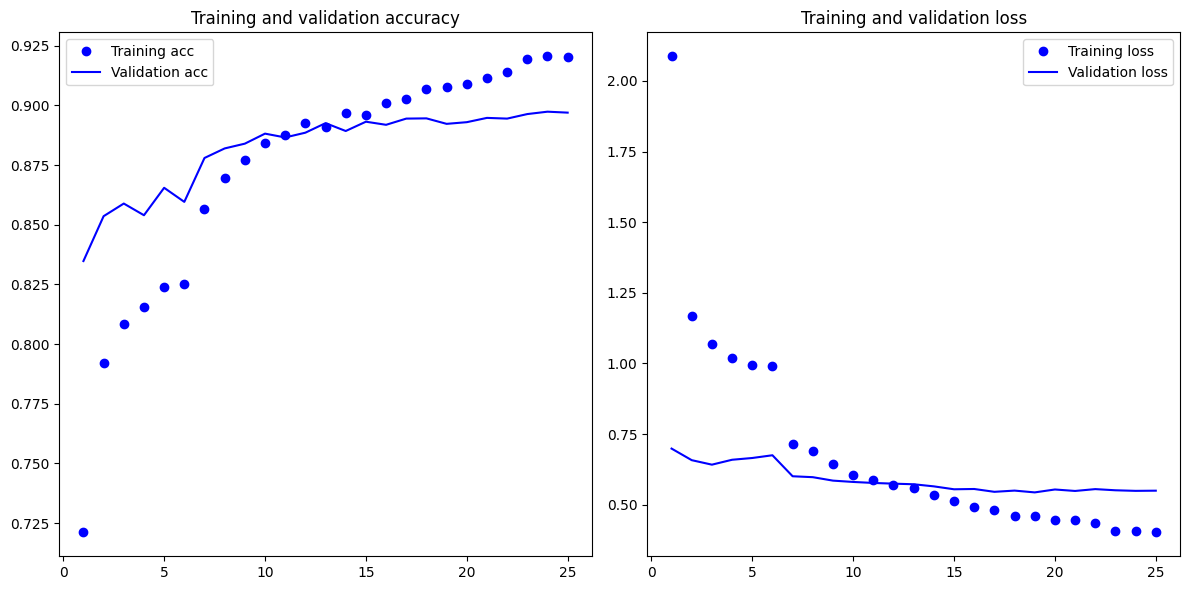

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

- Analyzing the training and validation, accuracy and loss over the epochs:
    - We see that the model begins overfitting slightly after the **16th** epoch.
    - The validation accuracy stops improving significantly after the **17th** epoch while the training accuracy keeps improving.
    - The validation loss stops improving significantly after the **17th** epoch while the training loss keeps improving.
    - The best model, based on validation loss, is saved on the **19th** epoch.
    - The training stops after the **25th** epoch because of the **Early Stopping** callback.

---
#### Building the Full Model with the VGG16 Convolutional Base and the Classifier

In [14]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
outputs = classifier(x)
model = keras.Model(inputs, outputs)

model.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=["accuracy"])

model.save('../models/05_model_t_tl_feat_ext_rmsprop_model.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 128, 128, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 model (Functional)          (None, 10)                4199946   
                                                                 
Total params: 18914634 (72.15 MB)
Trainable params: 4199946

---
#### Model Testing

In [15]:
test_labels = []
test_predictions = []
test_probabilities = []

for images, labels in test_dataset:
    test_labels.extend(labels.numpy())
    predictions = model.predict(images)
    test_predictions.extend(np.argmax(predictions, axis=-1))
    test_probabilities.extend(predictions)

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)

1/1 [==============================] - 0s 422ms/step


---
#### Confusion Matrix

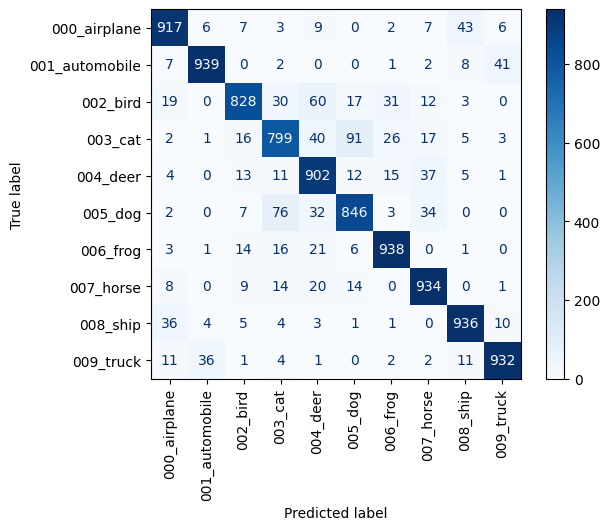

In [16]:
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

- Looking at the confusion matrix, we see that:  
    - The model has a hard time distinguishing the categories 003_cat and 005_dog.
    - The model has a very low performance on the category 003_cat.
    - The model performs better on the vehicle categories than on the animal categories.
    - The model has a below average performance on the categories 005_dog and 002_bird, in which we see a very high false positive rate.
    - The model also has a hard time distinguishing between some other categories but the deviation is not as significant.  
    - The model has an above average performance on the categories 000_airplane, 001_automobile, 006_frog, 008_ship and 009_truck.
    - **Basically, the model has the same error distribution but with higher accuracy**.

---
#### ROC Curve Analysis

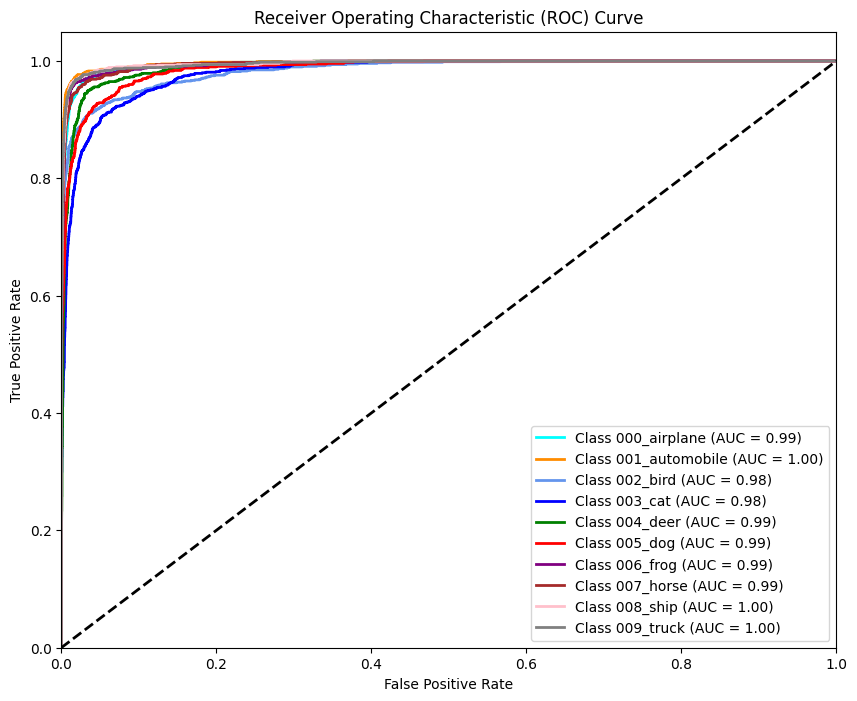

In [17]:
test_labels_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(test_labels_bin[:, i], test_probabilities[:, i])
    roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'grey'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(false_positive_rate[i], true_positive_rate[i], color=color, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

- Looking at the ROC curve:
    - We see that the model has a good performance on the ROC curve for most categories.  
    - The categories 003_cat and 002_bird have the worst AUC (Area Under Curve) performance.
    - The other categories have the same performance but with higher AUC.
    - The category 001_automobile, 008_ship and 009_truck has the best AUC performance.
    - The overall AUC performance increases as the false positive rate decreases and the true positive rate increases.
    - **A perfect AUC of 1.0 would mean that the model classifies all images either true positives or true negatives**.

---
#### Performance Metrics
- **Accuracy** is the proportion of correctly predicted instances out of the total instances.  
- **Precision** is the ratio of true positive predictions to the total predicted positives. Macro precision calculates this for each class independently and then averages them.  
- **Weighted precision** calculates the precision for each class, then averages them, weighted by the number of true instances for each class.  
- **Recall** is the ratio of true positive predictions to the total actual positives. Macro recall calculates this for each class independently and then averages them.  
- **Weighted recall** calculates the recall for each class, then averages them, weighted by the number of true instances for each class.  
- The **F1-score** is the harmonic mean of precision and recall. Macro F1-score calculates this for each class independently and then averages them.  
- **Weighted F1-score** calculates the F1-score for each class, then averages them, weighted by the number of true instances for each class.  

In [18]:
acc = accuracy_score(y_true =  test_labels, y_pred = test_predictions)
print(f'Accuracy : {np.round(acc*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 89.71%
Precision - Macro: 89.76%
Recall - Macro: 89.71%
F1-score - Macro: 89.69%
Precision - Weighted: 89.76%
Recall - Weighted: 89.71%
F1-score - Weighted: 89.69%


- **Since the dataset is balanced, the **MACRO** average is a good metric to evaluate the model.**

# Conclusion
### Summary
- Before this notebook:
    - We resized our images to be the 128 x 128 x 3.
    - Our reasoning was up scaling by a factor of 4. 

- In this notebook:
    - We extracted feature maps from our train and validation datasets using the convolutional base of the VGG16.
    - We trained a classifier with those extracted features:
        - We used the Root Mean Squared Propagation (RMSProp) optimizer with an initial learning rate of 0.001.
        - We kept the same 30 epochs with a batch size of 64.
    - We evaluated the classifier on the validation dataset:
        - Overfitting was observed after **16 epochs**, but the best classifier was saved at the **19th epoch**.
        - Training was intended for 30 epochs but stopped early due to the **Early Stopping** callback.
    - We then joined the VGG16 Convolutional Base with our Classifier
    - We tested the resulting model on the test set:
        - We evaluated the model using a confusion matrix to analyze its performance on each category.
        - We evaluated the model using ROC curves for a deeper performance analysis.
        - The model achieved an accuracy of 89.71% on the test set, which was a good improvement.

### Future Work
- In the next notebook:
    - Implement and train a transfer learning model with the VGG16 convolutional base frozen and a new classifier.
    - Experiment with **custom** data augmentation to improve classifier generalization
    - We will use 50 Epochs with a batch size of 64.
    - Test the model performance.